摄像头已打开
你点击了摄像头画面的点：(x=444, y=352)


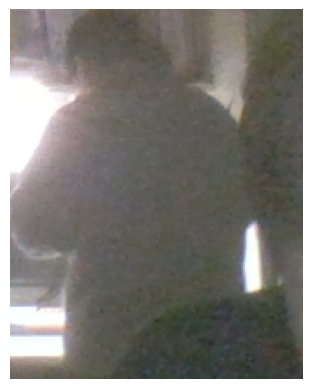

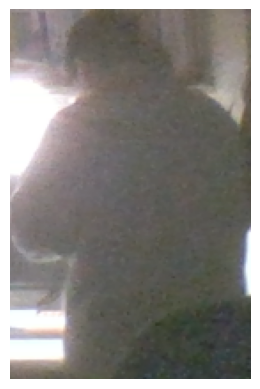

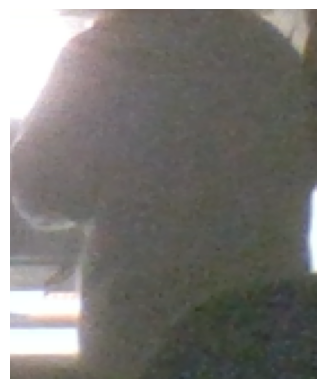

摄像头已打开
你点击了摄像头画面的点：(x=139, y=332)


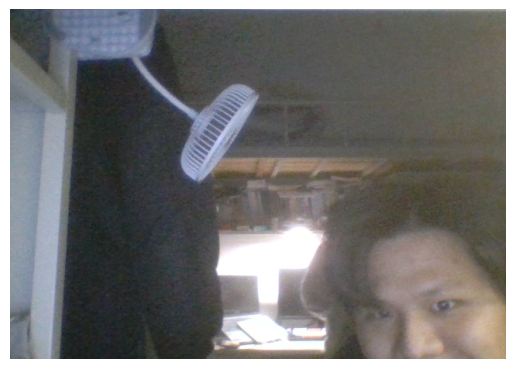

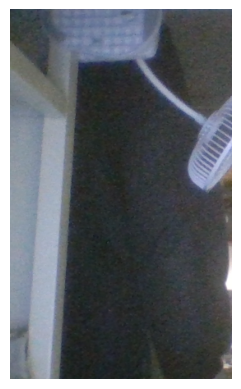

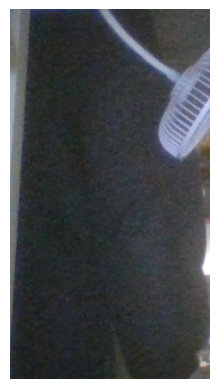

摄像头已打开
你点击了摄像头画面的点：(x=587, y=399)


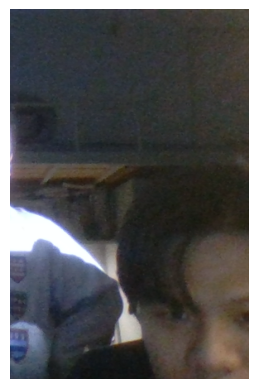

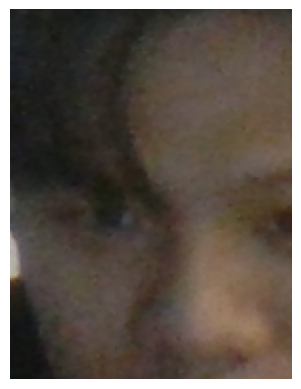

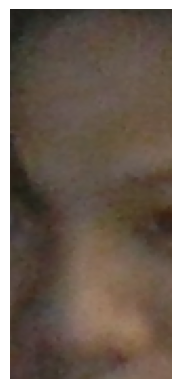

你点击了屏幕画面的点：(x=1140, y=1055)


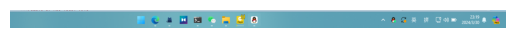

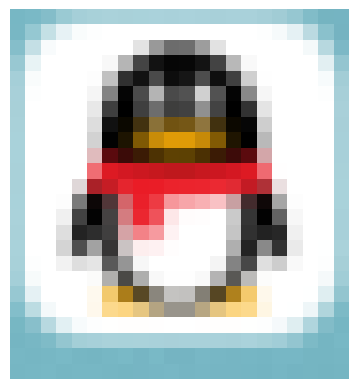

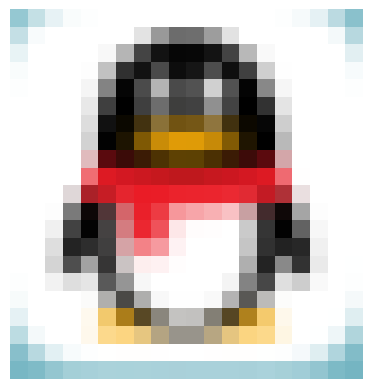

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import tkinter as tk
from PIL import Image, ImageTk
from pynput import mouse  # 使用 pynput 库监听鼠标点击事件
import pyscreenshot as ImageGrab  # 使用 pyscreenshot 库进行屏幕截取
import threading
from pystray import Icon, Menu, MenuItem
import io
# 初始化全局变量
square_regions = []
input_point_camera = None
input_point_screen = None
listener = None  # 鼠标监听器
app_visible = True  # 应用程序窗口是否可见

# 鼠标事件回调函数
def on_mouse_camera(event, x, y, flags, param):
    global input_point_camera
    input_point_camera = None
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'你点击了摄像头画面的点：(x={x}, y={y})')
        # 存储点击的坐标
        input_point_camera = np.array([[x, y]])
        # 清空之前的方块区域
        square_regions.clear()

# 启动摄像头
def start_camera():
    global square_regions
    
    square_regions = []

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('无法打开摄像头')
        return

    print('摄像头已打开')

    # 定义显示摄像头画面的函数
    def show_camera():
        while True:
            ret, frame = cap.read()
            if not ret:
                print('未能从摄像头读取画面')
                break

            cv2.imshow('Camera', frame)
            cv2.setMouseCallback('Camera', on_mouse_camera)

            key = cv2.waitKey(1) & 0xFF
            if input_point_camera is not None:
                predict_image_region(frame, input_point_camera)
                break

            if cv2.getWindowProperty('Camera', cv2.WND_PROP_VISIBLE) < 1:
                break

    # 在单独的线程中显示摄像头画面
    camera_thread = threading.Thread(target=show_camera)
    camera_thread.start()

    camera_thread.join()

    cap.release()
    cv2.destroyAllWindows()


# 在屏幕上预测图像区域
def predict_image_region(image, input_point):
    global square_regions

    sam_checkpoint = "sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = "cuda"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    predictor.set_image(image)

    input_label = np.array([1])

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        non_zero_indices = np.nonzero(mask)
        # 获取最上、最下、最左、最右的坐标
        topmost = np.min(non_zero_indices[0])
        bottommost = np.max(non_zero_indices[0])
        leftmost = np.min(non_zero_indices[1])
        rightmost = np.max(non_zero_indices[1])
        top, bottom, left, right = topmost, bottommost, leftmost, rightmost
        square_region = image[top:bottom + 1, left:right + 1]
        square_region_rgb = cv2.cvtColor(square_region, cv2.COLOR_BGR2RGB)
        square_regions.append(square_region_rgb)
        # 显示截取的方块区域
        plt.imshow(square_region_rgb)
        plt.axis('off')
        plt.show()

# 鼠标点击事件回调函数
def on_click(x, y, button, pressed):
    global input_point_screen, listener
    if pressed:
        print(f'你点击了屏幕画面的点：(x={x}, y={y})')
        input_point_screen = np.array([[x, y]])
        # 截图
        screenshot = ImageGrab.grab()
        screenshot = cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)
        threading.Thread(target=predict_image_region, args=(screenshot, input_point_screen)).start()
        listener.stop()  # 停止监听

# 开始监听鼠标点击事件
def start_listener():
    global listener
    listener = mouse.Listener(on_click=on_click)
    listener.start()

# 截取屏幕
def take_screenshot():
    start_listener()  # 开始监听

# 创建系统托盘图标
def create_tray_icon():
    icon_path = "icon.png"
    
    # Read the icon file
    with open(icon_path, "rb") as icon_file:
        icon_data = icon_file.read()
    
    # Convert the bytes to a PIL Image object
    icon_image = Image.open(io.BytesIO(icon_data))
    
    # Create the system tray icon
    icon = Icon("Camera Predictor", icon=icon_image, title="Camera Predictor")

    # Tray icon right-click menu
    menu = Menu(
        MenuItem('Start Camera', start_camera),
        MenuItem('Take Screenshot', take_screenshot),
        MenuItem('Exit', lambda: icon.stop()),
    )

    icon.menu = menu
    icon.run()

# 启动系统托盘图标
def start_tray_icon():
    threading.Thread(target=create_tray_icon).start()

# 启动应用程序
start_tray_icon()


In [ ]:
cv2.imwrite('square_region_0.jpg', cv2.cvtColor(square_regions[1], cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, 100])
local_file_path1 = 'file://F:/personal/2024_hackathon_project/segment-anything/notebooks/square_region_0.jpg'

In [ ]:
plt.imshow(square_regions[1])

In [ ]:
from dashscope import MultiModalConversation
from http import HTTPStatus
import dashscope
dashscope.api_key = 'sk-c8e61bbacecf4348b17f48812d4b5269'


def call_with_local_file():
    """Sample of use local file.
       linux&mac file schema: file:///home/images/test.png
       windows file schema: file://D:/images/abc.png
    """
    messages = [{
        'role': 'system',
        'content': [{
            'text': 'You are a one of the best English teacher in the world.I am a English person.'
        }]
    }, {
        'role':
        'user',
        'content': [
            {
                'image': local_file_path1
            },
            {
                'text': 'According to the objects shown in the picture, give the corresponding words, phonetic symbols and relevant example sentences,you dont need to send the picture back. If the object is complex, answer with the closest name.Please return in the following json format {"english_word","phonetic_symbols","relevant_example_sentences"}'
            },
        ]
    }]
    response = MultiModalConversation.call(model='qwen-vl-plus', messages=messages)
    print(response)
    return response


response_origin = call_with_local_file()

In [ ]:
response = response_origin
response['output']['choices'][0].message['content'][0]['text']

In [ ]:
input_point_screen= None
input_point_screen